# Botryllus brain analysis2
By: Atefe Rostami

# Packages

In [1]:
import warnings
import random
warnings.simplefilter(action = "ignore", category = FutureWarning)
import numpy as np
import pandas as pd
# import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from igraph import *
import csv
from igraph import *
# from MulticoreTSNE import MulticoreTSNE as TSNE #faster TSNE alternative
from anndata import read_h5ad
from anndata import read_text
# import bbknn
# import leidenalg
import seaborn as sns
#from gprofiler import GProfiler

from anndata import AnnData

import plotly.graph_objects as go
import plotly.offline as pyo


In [2]:
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", mpl.__version__)
print("seaborn version:", sns.__version__)


numpy version: 2.2.6
pandas version: 2.2.3
matplotlib version: 3.10.3
seaborn version: 0.13.2


In [3]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Initial data import


In [4]:
# Load the dataset
file_path = "../ci_brain_dec2023_counts_brain.txt"  # Update if needed
df = pd.read_csv(file_path, sep="\t")

# Pre_Processing

In [5]:
main_columns = [col for col in df.columns if col not in ["V1", "V2"]]

new_column_names = []
for col in main_columns:
    parts = col.split("_")  # Splitting by "_"

    try:
        sample_id = parts[3]  # ILWXYZ (Sample ID)
        region = parts[5]  # Region (B2, AB)

        # Ensure "19_months" is not split
        if parts[12].isdigit() and parts[13] == "months":
            age = f"{parts[12]}_{parts[13]}"  # "19_months"
            replicate = parts[9]  # Replicate (pXXcXXrXX)
            sample_number = parts[14]  # Sample Number (SXXX)
        else:
            age = "Unknown"  # If structure doesn't match, label as unknown
            replicate = parts[-4] if len(parts) > 4 else "Unknown"
            sample_number = parts[-3] if len(parts) > 3 else "Unknown"

        # Construct the new column name in the expected format
        new_col_name = f"{sample_id}-{region}-{age}-{replicate}-{sample_number}"
    except IndexError:
        new_col_name = col  # Keep original if unexpected format

    new_column_names.append(new_col_name)

# Rename columns in DataFrame
df.columns = ["Gene_ID", "Gene_Name"] + new_column_names
display(df.head())

,Gene_ID,Gene_Name,ILW100-B2-19_months-p05c01r01-S385,ILW100-B2-19_months-p05c05r02-S401,ILW100-B2-19_months-p05c09r03-S417,ILW100-B2-19_months-p05c01r05-S433,ILW100-B2-19_months-p05c05r06-S449,ILW100-B2-19_months-p05c09r07-S465,ILW101-B2-19_months-p06c01r01-S481,ILW101-B2-19_months-p06c05r02-S497,...,ILW105-AB-19_months-p10c12r04-S912,ILW106-AB-19_months-p10c04r06-S928,ILW106-AB-19_months-p10c08r07-S944,ILW106-AB-19_months-p10c12r08-S960,ILW106-AB-19_months-p11c04r02-S976,ILW106-AB-19_months-p11c08r03-S992,ILW106-AB-19_months-p11c12r04-S1008,ILW107-AB-19_months-p11c04r06-S1024,ILW107-AB-19_months-p11c08r07-S1040,ILW107-AB-19_months-p11c12r08-S1056
0,FUN_000001,NaN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,FUN_000002,DNAJB11_1,0,0,0,0,0,0,0,0,...,0,0,0,16,0,0,0,0,0,0
2,FUN_000003,NaN,0,0,0,0,0,0,0,0,...,0,0,0,3,10,0,0,0,0,0
3,FUN_000004,NaN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,FUN_000005,SMU1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Filename Structure Reference

 Key Components:
 
- **Plate**: `PAC4_PlateX` (e.g., PAC4_Plate1, PAC4_Plate2)
- **Well**: `A01`, `B02`, `C03`, ... (Position in the plate)
- **Sample ID**: `ILWXYZ` (Unique identifier for the sample)
- **Tissue**: `Brain`
- **Tipe of cell (in time)**: `B2`, `AB` (Specific brain region)
- **Cell Size**: `small`, `large`
- **Replicate**: `pXXcXXrXX` (Pattern: plateX_cellX_repX)
- **Age**: `19_months` (or other time points)
- **Sample Number**: `SXXX` (e.g., S101, S202)
- **File Type**: `.bam.counts` (Processed count file)



sampleid- region- age-replicate-sample number

## Detecting duplications


In [6]:
# Count NaN values in the 'Gene_ID' column
nan_count = df['Gene_ID'].isna().sum()

print(f"Number of NaN values in 'Gene_ID': {nan_count}")

# Count NaN values in the 'Gene_ID' column
nan_count = df['Gene_Name'].isna().sum()

print(f"Number of NaN values in 'Gene_Name': {nan_count/df.shape[0]}")
# Check for duplicate Gene_IDs
gi_duplicates = df['Gene_ID'].duplicated().any()
gene_name_duplicates = df['Gene_Name'].duplicated().any()
print(f"Duplicate values in 'Gene_ID': {gi_duplicates}")
print(f"Duplicate values in 'Gene_Name': {gene_name_duplicates}")
# Create a mapping from old Gene_ID to new format
df = df.iloc[:-5]
df['Gene_ID'] = df['Gene_ID'].str.extract(r'(\d+)').astype(str)  # Extract numbers
df['Gene_ID'] = 'g' + df['Gene_ID'].astype(str)  # Convert to 'g1', 'g2', etc.
df['Gene_ID'] = df['Gene_ID'].str.replace(r'g0*', 'g', regex=True)
df['Gene_Name'].fillna(df['Gene_ID'], inplace=True)
df["g_unique"] = df["Gene_ID"] + "_" + df["Gene_Name"]
first_col = df.pop('g_unique')  # Remove the column and store it
df.insert(0, 'g_unique', first_col)

display(df.head(3))

# set GI as index
df.set_index('Gene_ID', inplace=True)
# remove "GI", the name of the index
df.index.name = None

# remove the rows which index does not start with "g" (eg. "g1")
df_cleaned = df[df.index.str.startswith('g')]
print(df.shape, df_cleaned.shape)

display(df_cleaned.head())

# save a new df without Gene_Note and Gene_Name columns
df_sel = df_cleaned.drop(['Gene_Name'], axis=1)

df_sel.set_index('g_unique', inplace=True)
df_sel.index.name = None

df_sel.head()



Number of NaN values in 'Gene_ID': 0
Number of NaN values in 'Gene_Name': 0.7462666547438076
Duplicate values in 'Gene_ID': False
Duplicate values in 'Gene_Name': True


,g_unique,Gene_ID,Gene_Name,ILW100-B2-19_months-p05c01r01-S385,ILW100-B2-19_months-p05c05r02-S401,ILW100-B2-19_months-p05c09r03-S417,ILW100-B2-19_months-p05c01r05-S433,ILW100-B2-19_months-p05c05r06-S449,ILW100-B2-19_months-p05c09r07-S465,ILW101-B2-19_months-p06c01r01-S481,...,ILW105-AB-19_months-p10c12r04-S912,ILW106-AB-19_months-p10c04r06-S928,ILW106-AB-19_months-p10c08r07-S944,ILW106-AB-19_months-p10c12r08-S960,ILW106-AB-19_months-p11c04r02-S976,ILW106-AB-19_months-p11c08r03-S992,ILW106-AB-19_months-p11c12r04-S1008,ILW107-AB-19_months-p11c04r06-S1024,ILW107-AB-19_months-p11c08r07-S1040,ILW107-AB-19_months-p11c12r08-S1056
0,g1_g1,g1,g1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,g2_DNAJB11_1,g2,DNAJB11_1,0,0,0,0,0,0,0,...,0,0,0,16,0,0,0,0,0,0
2,g3_g3,g3,g3,0,0,0,0,0,0,0,...,0,0,0,3,10,0,0,0,0,0


(44727, 685) (44727, 685)


,g_unique,Gene_Name,ILW100-B2-19_months-p05c01r01-S385,ILW100-B2-19_months-p05c05r02-S401,ILW100-B2-19_months-p05c09r03-S417,ILW100-B2-19_months-p05c01r05-S433,ILW100-B2-19_months-p05c05r06-S449,ILW100-B2-19_months-p05c09r07-S465,ILW101-B2-19_months-p06c01r01-S481,ILW101-B2-19_months-p06c05r02-S497,...,ILW105-AB-19_months-p10c12r04-S912,ILW106-AB-19_months-p10c04r06-S928,ILW106-AB-19_months-p10c08r07-S944,ILW106-AB-19_months-p10c12r08-S960,ILW106-AB-19_months-p11c04r02-S976,ILW106-AB-19_months-p11c08r03-S992,ILW106-AB-19_months-p11c12r04-S1008,ILW107-AB-19_months-p11c04r06-S1024,ILW107-AB-19_months-p11c08r07-S1040,ILW107-AB-19_months-p11c12r08-S1056
g1,g1_g1,g1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
g2,g2_DNAJB11_1,DNAJB11_1,0,0,0,0,0,0,0,0,...,0,0,0,16,0,0,0,0,0,0
g3,g3_g3,g3,0,0,0,0,0,0,0,0,...,0,0,0,3,10,0,0,0,0,0
g4,g4_g4,g4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
g5,g5_SMU1,SMU1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,ILW100-B2-19_months-p05c01r01-S385,ILW100-B2-19_months-p05c05r02-S401,ILW100-B2-19_months-p05c09r03-S417,ILW100-B2-19_months-p05c01r05-S433,ILW100-B2-19_months-p05c05r06-S449,ILW100-B2-19_months-p05c09r07-S465,ILW101-B2-19_months-p06c01r01-S481,ILW101-B2-19_months-p06c05r02-S497,ILW101-B2-19_months-p06c09r03-S513,ILW101-B2-19_months-p06c01r05-S529,...,ILW105-AB-19_months-p10c12r04-S912,ILW106-AB-19_months-p10c04r06-S928,ILW106-AB-19_months-p10c08r07-S944,ILW106-AB-19_months-p10c12r08-S960,ILW106-AB-19_months-p11c04r02-S976,ILW106-AB-19_months-p11c08r03-S992,ILW106-AB-19_months-p11c12r04-S1008,ILW107-AB-19_months-p11c04r06-S1024,ILW107-AB-19_months-p11c08r07-S1040,ILW107-AB-19_months-p11c12r08-S1056
g1_g1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
g2_DNAJB11_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,16,0,0,0,0,0,0
g3_g3,0,0,0,0,0,0,0,0,0,3,...,0,0,0,3,10,0,0,0,0,0
g4_g4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
g5_SMU1,0,0,0,0,0,0,0,0,9,0,...,0,0,0,0,0,0,0,0,0,0


**df_sel** is the cleaned input dataset. Ready for more processing

## AnnData

In [7]:
# adata = AnnData(df_sel)
# Transpose the DataFrame to have genes as rows and cells as columns
# obs is the cell/sample IDs
# var is the gene IDs/names
adata = AnnData(X=df_sel.T.values, obs=pd.DataFrame(index=df_sel.columns), var=pd.DataFrame(index=df_sel.index))

# print first 4 row names and first 4 column names
print(adata.obs_names[:4])  # First 4 cell/sample IDs
print(adata.var_names[:4])  # First 4 gene IDs/names
print(adata.shape)          # Shape: (cells, genes)


Index(['ILW100-B2-19_months-p05c01r01-S385',
       'ILW100-B2-19_months-p05c05r02-S401',
       'ILW100-B2-19_months-p05c09r03-S417',
       'ILW100-B2-19_months-p05c01r05-S433'],
      dtype='object')
Index(['g1_g1', 'g2_DNAJB11_1', 'g3_g3', 'g4_g4'], dtype='object')
(683, 44727)


In [8]:
import scipy.sparse

print(type(adata.X))

# Or check if it's sparse
if scipy.sparse.issparse(adata.X):
    print("adata.X is a sparse matrix.")
else:
    print("adata.X is a dense NumPy array.")


<class 'numpy.ndarray'>
adata.X is a dense NumPy array.


adata.X is your expression matrix (cells × genes).

.sum(axis=1) sums counts across all genes for each cell, giving the total counts per cell.


In [9]:
# Parse sample metadata from cell/sample names and store as separate columns in adata.obs
# Extracts Sample_ID, Region, Age, Replicate, and Sample_Number from the sample name string
adata.obs['Sample_ID'] = [i.split('-')[0] for i in adata.obs_names] 
adata.obs['Region'] =    [i.split('-')[1] for i in adata.obs_names]
adata.obs['Age'] =       [i.split('-')[2] for i in adata.obs_names]
adata.obs['Replicate'] = [i.split('-')[3] for i in adata.obs_names]
adata.obs['Sample_Number'] = [i.split('-')[4] for i in adata.obs_names]

print(adata.shape)


(683, 44727)


**Check** the format of the matrix

In [10]:
# Sum along the columns (genes)
# adata.X is a sparse matrix, so we need to convert it to a dense format first
total_counts = adata.X.sum(axis=1)
print(total_counts.shape)

(683,)


## Quality control

In [12]:
import scanpy as sc  # Ensure scanpy is imported

# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1) # total counts per cell
adata.obs['n_genes'] = (adata.X > 0).sum(1) # number of expressed genes per cell
adata = adata[adata.obs['n_counts']>=100]
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=10)

/tmp/ipykernel_20286/1097839567.py:4: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.

/home/pissmaster/Desktop/Botryllus brain/Butryllus_Brain_scRNAseq/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:170: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



In [13]:
print(adata.obs.shape)

(581, 7)


In [14]:
# Zeros fraction
zeros_perGene_frac = np.sum(adata.X == 0, axis=0) / adata.X.shape[0]

genes_above = zeros_perGene_frac[zeros_perGene_frac > 0.95]
num_genes_above = len(genes_above)/adata.X.shape[1]
print("Number of genes with a fraction of zeros above :", num_genes_above)

# plt.figure(figsize=(6,3))
# sns.histplot(zeros_perGene_frac, bins=80, color='skyblue', stat='density')
# plt.xlim(0.85,1)



Number of genes with a fraction of zeros above : 0.38449993177786873


In [15]:
print(adata.shape)

(581, 14658)


# Normalization

## LogNorm

It adjusts for sequencing depth differences across cells — like converting all cells to the same "library size."

Think of it like converting raw counts to counts per 10,000 (CP10K), similar to CPM (counts per million).

In [16]:
# Step 1: Normalize total counts per cell
sc.pp.normalize_total(adata, target_sum=1e4)

# Step 2: Logarithmize the data log(x+1)
sc.pp.log1p(adata)



# PCA

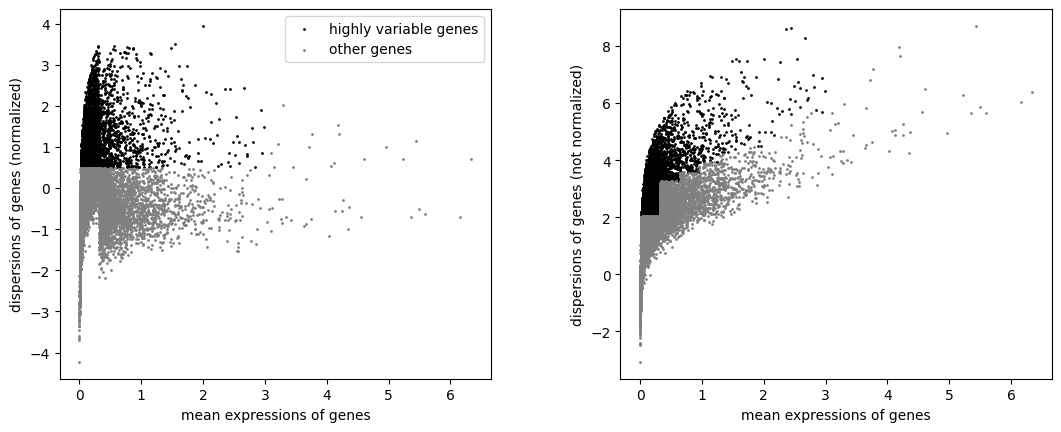

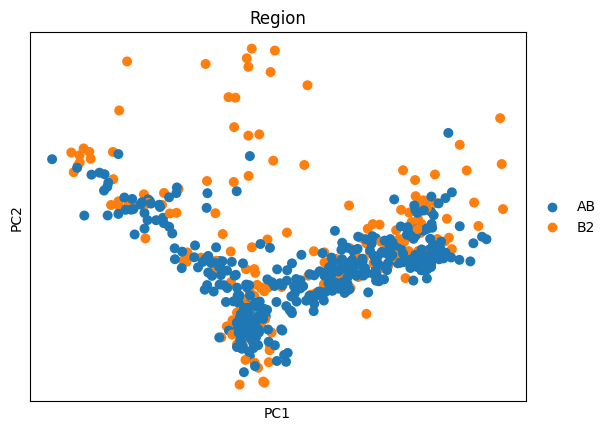

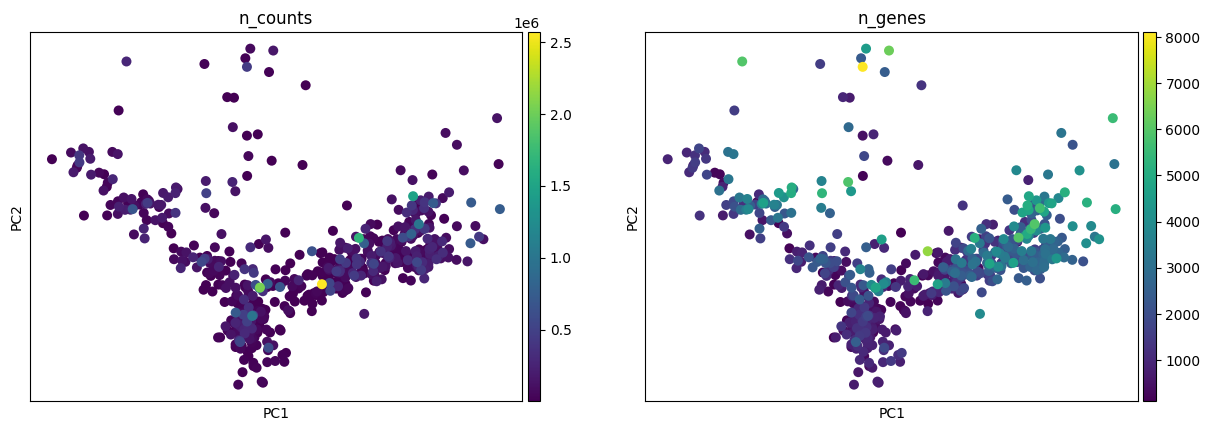

In [17]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Plot highly variable genes
sc.pl.highly_variable_genes(adata)

# Run PCA using HVGs
sc.tl.pca(adata, svd_solver = 'arpack', use_highly_variable=True)

# Plot PCA
sc.pl.pca(adata, color=['Region'])

# Plot PCA with n_counts and n_genes
sc.pl.pca_scatter(adata, color=['n_counts', 'n_genes'])

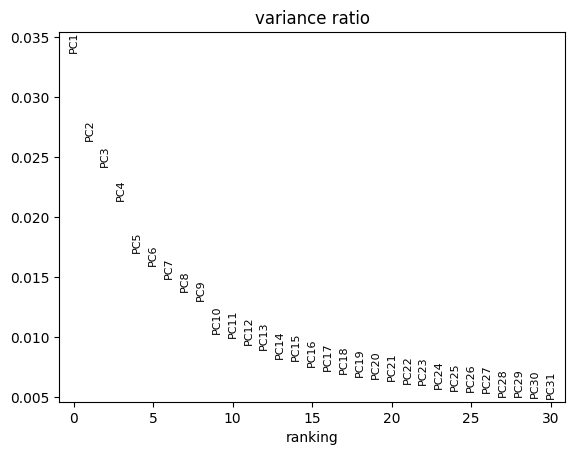

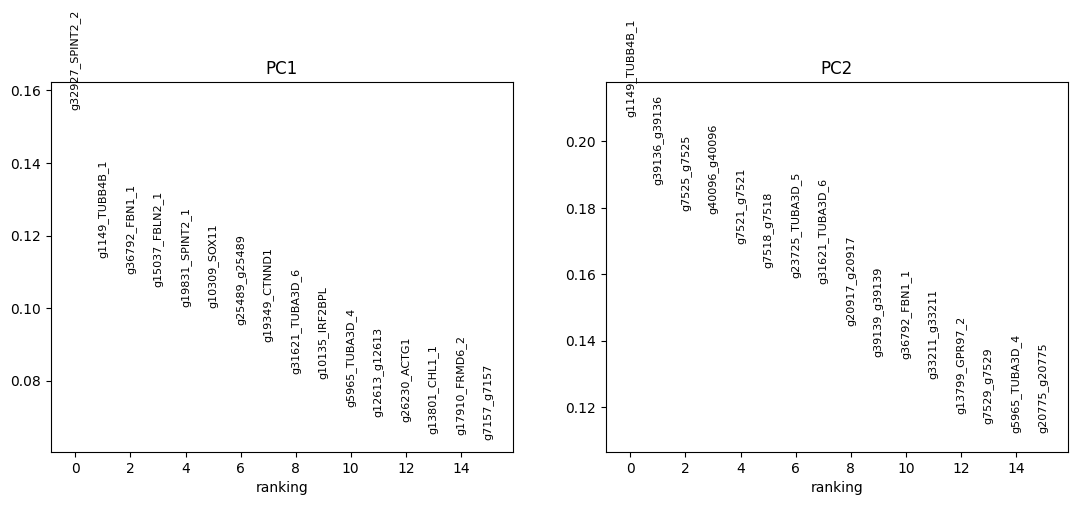

In [18]:
# pca variance ratio
sc.pl.pca_variance_ratio(adata, log=False)

# PCA loadings (genes contributing to PCs)
sc.pl.pca_loadings(adata, components='1,2', show=False, include_lowest=False, n_points=15)

# Dimensionality Reduction UMAP


## umap(nn=25,npcs=5,metrics=cosine)

For each cell, look at the first 6 PCA dimensions, and find the 25 most similar cells using cosine distance.

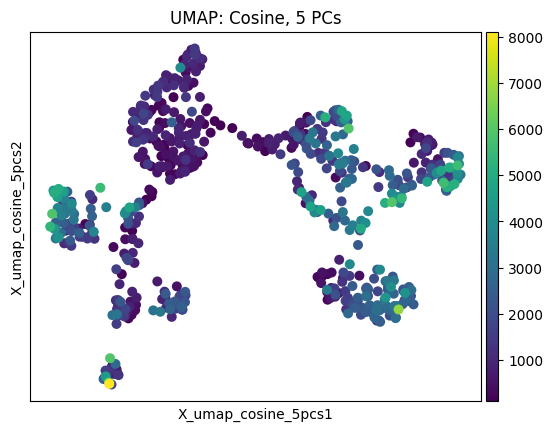

In [83]:
sc.pp.neighbors(adata, n_neighbors=25, n_pcs=5, random_state=0, metric='cosine')
sc.tl.umap(adata)

# Save UMAP coordinates
adata.obsm['X_umap_cosine_5pcs'] = adata.obsm['X_umap'].copy()

# Save neighbor graph
adata.uns['neighbors_cosine_5pcs'] = adata.uns['neighbors']
adata.obsp['connectivities_cosine_5pcs'] = adata.obsp['connectivities'].copy()
adata.obsp['distances_cosine_5pcs'] = adata.obsp['distances'].copy()

# Plot it
sc.pl.embedding(adata, basis='X_umap_cosine_5pcs', color='n_genes', title='UMAP: Cosine, 5 PCs')

## umap(nn=25,npcs=5,metrics=euclidean)

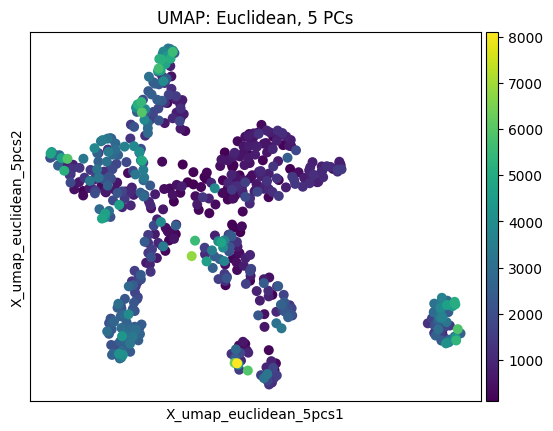

In [69]:
sc.pp.neighbors(adata, n_neighbors=25, n_pcs=5, random_state=0, metric='euclidean')
sc.tl.umap(adata)

# Save UMAP coordinates
adata.obsm['X_umap_euclidean_5pcs'] = adata.obsm['X_umap'].copy()

# Save neighbor graph (optional but useful)
adata.uns['neighbors_euclidean_5pcs'] = adata.uns['neighbors']
adata.obsp['connectivities_euclidean_5pcs'] = adata.obsp['connectivities'].copy()
adata.obsp['distances_euclidean_5pcs'] = adata.obsp['distances'].copy()

# Plot UMAP
sc.pl.embedding(adata, basis='X_umap_euclidean_5pcs', color='n_genes', title='UMAP: Euclidean, 5 PCs')



In [20]:
# # Restore cosine neighbors if you want to cluster using that graph again
# adata.uns['neighbors'] = adata.uns['neighbors_cosine_6pcs']
# adata.obsp['connectivities'] = adata.obsp['connectivities_cosine_6pcs']
# adata.obsp['distances'] = adata.obsp['distances_cosine_6pcs']

# # Then you can run clustering (e.g. Leiden)
# sc.tl.leiden(adata, resolution=0.5)
# sc.pl.embedding(adata, basis='X_umap_cosine_6pcs', color='leiden')


## Save UMAP

In [21]:
# adata.write('my_analysis_with_multiple_umaps.h5ad')

# Clustering (Leiden and DBSCAN)

In [88]:
import scanpy as sc
from sklearn.cluster import DBSCAN

def run_umap_and_cluster(
    adata,
    nn,
    npcs,
    metric,
    leiden_resolution=0.58,
    dbscan_eps=0.5,
    dbscan_min_samples=5
):
    # Step 1: Compute neighbors
    sc.pp.neighbors(adata, n_neighbors=nn, n_pcs=npcs, metric=metric, random_state=0)
    
    # Step 2: Compute UMAP
    sc.tl.umap(adata)
    
    # Save UMAP embedding with flag in obsm
    umap_key = f'X_umap_nn{nn}_pcs{npcs}_{metric}'
    adata.obsm[umap_key] = adata.obsm['X_umap'].copy()
    
    # Step 3: Leiden clustering
    leiden_key = f'leiden_res{leiden_resolution}_nn{nn}_pcs{npcs}_{metric}'
    sc.tl.leiden(adata, resolution=leiden_resolution, key_added=leiden_key)
    
    # Step 4: DBSCAN clustering on the UMAP embedding
    dbscan = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples, metric=metric)
    dbscan_labels = dbscan.fit_predict(adata.obsm[umap_key])
    dbscan_key = f'dbscan_eps{dbscan_eps}_min{dbscan_min_samples}_nn{nn}_pcs{npcs}_{metric}'
    adata.obs[dbscan_key] = dbscan_labels.astype(str)
    
    # Return keys for later use
    return {
        'umap_key': umap_key,
        'leiden_key': leiden_key,
        'dbscan_key': dbscan_key
    }


## Heatmap


Processing clustering: leiden_res0.5_nn25_pcs5_cosine


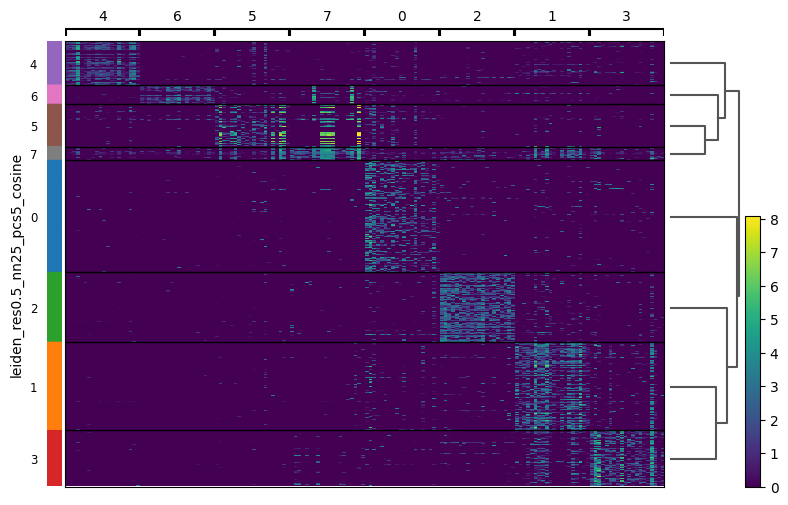


Processing clustering: leiden_res0.5_nn25_pcs5_euclidean


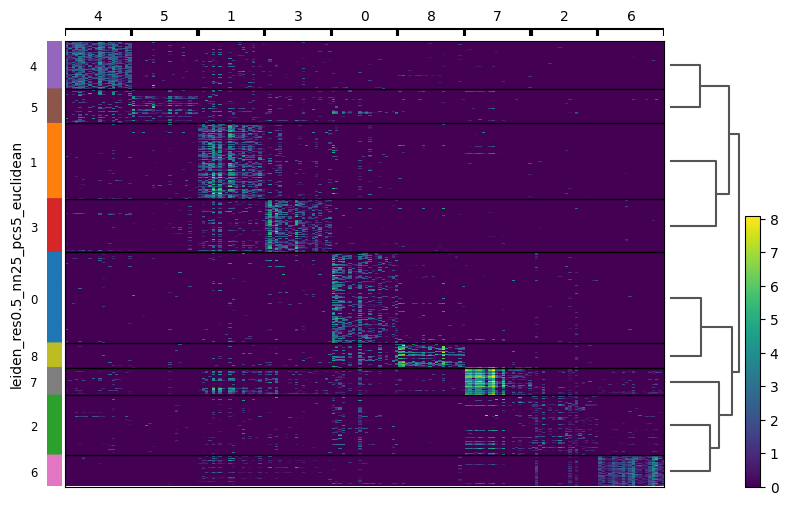

In [157]:
clusterings = [
    'leiden_res0.5_nn25_pcs5_cosine',
    'leiden_res0.5_nn25_pcs5_euclidean'
]

for clust_key in clusterings:
    print(f"\nProcessing clustering: {clust_key}")
    
    # Rank genes per cluster (Wilcoxon)
    sc.tl.rank_genes_groups(
        adata,
        groupby=clust_key,
        method='wilcoxon',
        tie_correct=True,
        pts=True,
        key_added=f'wilcoxon_{clust_key}'
    )
    
    # Plot heatmap of top 20 marker genes
    sc.pl.rank_genes_groups_heatmap(
        adata,
        n_genes=20,
        groupby=clust_key,
        key=f'wilcoxon_{clust_key}',
        show=True
    )


In [155]:
results_cosine = run_umap_and_cluster(
    adata,
    nn=25,
    npcs=5,
    metric='cosine',
    leiden_resolution=0.58,
    dbscan_eps=0.00045,
    dbscan_min_samples=5
)

results_euclidean = run_umap_and_cluster(
    adata,
    nn=25,
    npcs=7,
    metric='euclidean',
    leiden_resolution=0.5,
    dbscan_eps=0.6,
    dbscan_min_samples=5
)


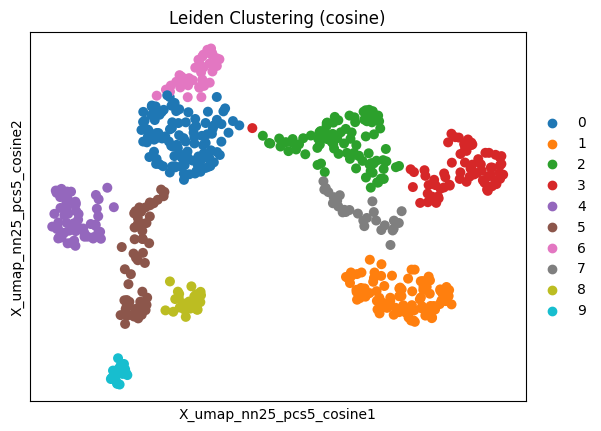

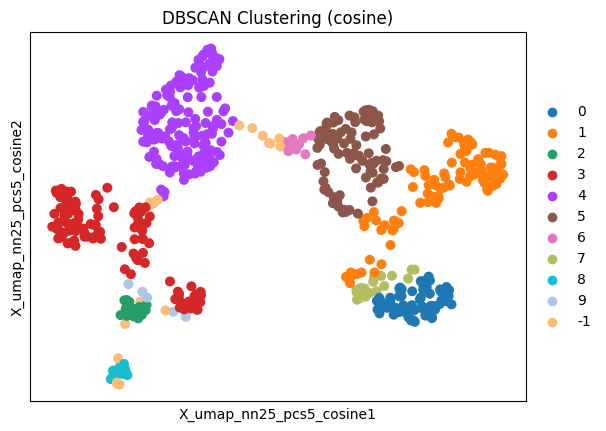

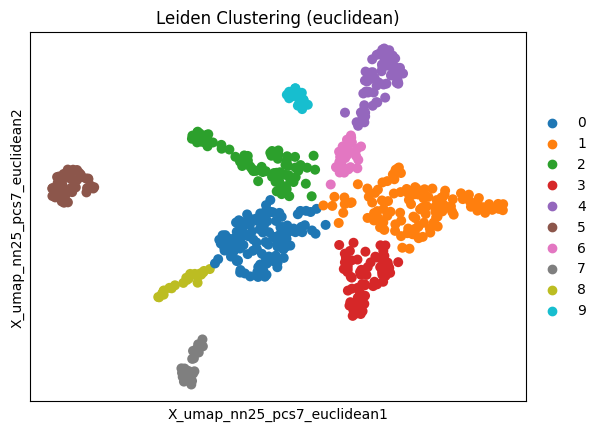

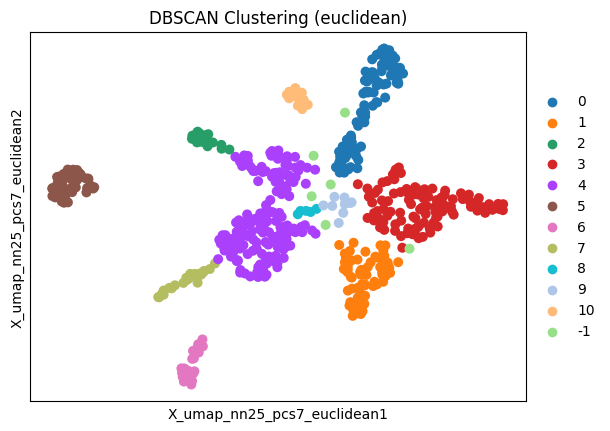

In [156]:
# Plot UMAP colored by Leiden for cosine
sc.pl.embedding(adata, basis=results_cosine['umap_key'], color=results_cosine['leiden_key'], title='Leiden Clustering (cosine)')

# Plot UMAP colored by DBSCAN for cosine
sc.pl.embedding(adata, basis=results_cosine['umap_key'], color=results_cosine['dbscan_key'], title='DBSCAN Clustering (cosine)')

# Plot UMAP colored by Leiden for euclidean
sc.pl.embedding(adata, basis=results_euclidean['umap_key'], color=results_euclidean['leiden_key'], title='Leiden Clustering (euclidean)')

# Plot UMAP colored by DBSCAN for euclidean
sc.pl.embedding(adata, basis=results_euclidean['umap_key'], color=results_euclidean['dbscan_key'], title='DBSCAN Clustering (euclidean)')


# Marker gene finding

## Finding the marker genes in each cluster

In [22]:
def extract_suffix(s):
    parts = s.split('_')
    return parts[1] if len(parts) > 1 else s

In [23]:
marker_genes = pd.DataFrame(adata.uns['wilcoxon_leiden']['names'])

marker_genes.to_csv('Botryllus_brain_marker_genes_25_5_eu.csv')
marker_genes.head(5)

,0,1,2,3,4,5,6,7,8,9,10
0,g29898_g29898,g28724_SPON1_4,g7168_g7168,g25332_g25332,g38720_g38720,g32408_g32408,g32668_g32668,g33974_g33974,g37192_g37192,g9499_g9499,g23581_g23581
1,g19347_g19347,g23053_g23053,g10186_g10186,g26229_g26229,g41771_GPR20_11,g21413_g21413,g13777_CYP2R1_2,g14844_g14844,g8479_g8479,g3206_g3206,g26235_g26235
2,g26701_g26701,g29648_g29648,g7198_SOGA1,g5965_TUBA3D_4,g37869_g37869,g8825_lon-1_2,g7518_g7518,g8477_g8477,g34198_g34198,g8979_g8979,g4022_g4022
3,g9451_MEOX2,g29024_g29024,g13801_CHL1_1,g26227_g26227,g13799_GPR97_2,g28841_g28841,g38776_g38776,g36746_g36746,g18019_g18019,g35833_TLDC2,g3025_g3025
4,g12560_g12560,g12622_g12622,g6964_EBF2,g36516_g36516,g10899_g10899,g19140_g19140,g7529_g7529,g10513_SLC5A5_4,g37193_g37193,g26585_g26585,g716_PTTG1IP_1


With just gene name

In [24]:
# Extract DEGs info
rank_key = 'wilcoxon_leiden'
names1 = pd.DataFrame(adata.uns[rank_key]['names'])  # Convert recarray to DataFrame
names = names1.applymap(extract_suffix)
logfcs = adata.uns[rank_key]['logfoldchanges']
pvals = adata.uns[rank_key]['pvals']

# Convert to DataFrames
names_df = pd.DataFrame(names)
logfc_df = pd.DataFrame(logfcs)
pval_df = pd.DataFrame(pvals)

# Rename columns to match cluster names
names_df.columns = [f"{col}" for col in names_df.columns]
logfc_df.columns = [f"{col}_logFC" for col in logfc_df.columns]
pval_df.columns = [f"{col}_pval" for col in pval_df.columns]


# Build new DataFrame with interleaved columns
combined_df = pd.DataFrame()

for cluster in names_df.columns:
    combined_df[cluster] = names_df[cluster]
    combined_df[f"{cluster}_logFC"] = logfc_df[f"{cluster}_logFC"]
    combined_df[f"{cluster}_pval"] = pval_df[f"{cluster}_pval"]

# Save or preview
combined_df.to_csv("marker_genes_with_logfc_pval.csv", index=False)
combined_df.head()


,0,0_logFC,0_pval,1,1_logFC,1_pval,2,2_logFC,2_pval,3,...,7_pval,8,8_logFC,8_pval,9,9_logFC,9_pval,10,10_logFC,10_pval
0,g29898,4.951141,1.319549e-43,SPON1,6.109845,1.365523e-48,g7168,7.171802,1.009132e-84,g25332,...,1.160016e-72,g37192,6.482347,8.414908e-55,g9499,9.019714,1.871522e-78,g23581,12.565420,7.193058e-117
1,g19347,4.843396,9.084103e-42,g23053,4.922610,1.250901e-40,g10186,6.593122,1.465991e-78,g26229,...,2.833910e-72,g8479,6.642782,7.846954e-52,g3206,9.404484,3.818137e-66,g26235,10.667176,1.508857e-116
2,g26701,4.571348,1.880851e-33,g29648,4.969918,2.064234e-40,SOGA1,6.979280,3.662508e-77,TUBA3D,...,1.285830e-67,g34198,6.634995,1.215030e-50,g8979,9.717744,3.132396e-59,g4022,14.573607,1.778160e-107
3,MEOX2,3.764997,1.464419e-32,g29024,4.538191,7.769284e-40,CHL1,6.464045,1.907110e-71,g26227,...,7.435604e-66,g18019,5.973525,2.311130e-48,TLDC2,8.593803,4.156238e-59,g3025,12.129919,2.498989e-107
4,g12560,4.067230,3.458760e-26,g12622,4.227538,4.449411e-39,EBF2,6.460234,5.648572e-70,g36516,...,3.206277e-65,g37193,6.655671,9.575829e-45,g26585,7.828346,4.566807e-59,PTTG1IP,13.685336,3.974087e-104


## Finding the marker genes (Only annotated markers)

In [27]:

# (1) build your three original DataFrames as before
rk        = 'wilcoxon_leiden'
names1    = pd.DataFrame(adata.uns[rk]['names']).applymap(extract_suffix)
names2    = names1.applymap(lambda x: None 
                            if isinstance(x,str) and x.startswith('g') and x[1:].isdigit() 
                            else x)
names_df  = names2.dropna(axis=1, how='all').copy()

lfc_df    = pd.DataFrame(adata.uns[rk]['logfoldchanges'])
lfc_df.columns = [f"{c}_logFC" for c in lfc_df.columns]

pval_df   = pd.DataFrame(adata.uns[rk]['pvals'])
pval_df.columns = [f"{c}_pval" for c in pval_df.columns]


# (2) build your output DataFrame, cluster by cluster
out = pd.DataFrame()
for cl in names_df.columns:
    mask = names_df[cl].notna()
    # pull just the valid rows for this cluster and reset index
    genes  = names_df.loc[mask, cl].reset_index(drop=True)
    logs   = lfc_df .loc[mask, f"{cl}_logFC"].reset_index(drop=True)
    pvs    = pval_df.loc[mask, f"{cl}_pval"].reset_index(drop=True)

    out[cl]           = genes
    out[f"{cl}_logFC"] = logs
    out[f"{cl}_pval"]  = pvs

# (3) preview
print(out.head())


       0   0_logFC        0_pval       1   1_logFC        1_pval        2  \
0  MEOX2  3.764997  1.464419e-32   SPON1  6.109845  1.365523e-48    SOGA1   
1   SPE1  4.268008  1.717821e-21   LAMB1  3.788480  1.427775e-37     CHL1   
2  OPRL1  4.321793  1.739437e-20    FBN1  4.601896  3.040106e-37     EBF2   
3   SPE1  4.161423  7.626036e-20    KLF5  3.998403  3.758512e-36  CACNA1E   
4   RTP4  2.659846  4.338333e-17  SLC51A  4.094206  1.094914e-35     CPN1   

    2_logFC        2_pval       3  ...        7_pval      8   8_logFC  \
0  6.979280  3.662508e-77  TUBA3D  ...  3.206277e-65   NME5  5.924939   
1  6.464045  1.907110e-71   ACTG1  ...  1.506026e-63  STPG2  4.307589   
2  6.460234  5.648572e-70  CCDC65  ...  8.904131e-56  TEKT3  5.614094   
3  5.513160  5.381474e-68   FOXQ1  ...  1.599303e-52   FGF9  5.501581   
4  6.149725  1.258003e-66    CIB1  ...  3.432722e-52   KAL1  4.681580   

         8_pval        9   9_logFC        9_pval       10   10_logFC  \
0  1.612468e-33    TLDC2  

## Finding the marker genes (Only annotated markers) just gene names

In [28]:
import re 
# Creazione di marker_annotated con la stessa struttura di marker_genes_cl
marker_genes_cl = marker_genes.applymap(extract_suffix)

marker_annotated = marker_genes_cl.copy()
marker_annotated_only_genes = marker_genes_cl.copy()

# Iterazione attraverso ciascuna colonna di marker_genes_cl
for col in marker_genes.columns:
    # Dividi ogni elemento della colonna per trovare la parte prima e dopo il "_"
    parts = marker_genes[col].str.split('_', n=1, expand=True)
    # Applica la pulizia alla parte successiva al "_"
    # cleaned_part = parts[1].apply(lambda x: x if pd.isna(x) or not re.match(r'^g\d+|^$', x) else np.nan)
    cleaned_part = parts[1].apply(lambda x: x if pd.isna(x) or not re.match(r'^g\d+|^\d+$|^$', x) else np.nan)
    # Combina le due parti in una nuova colonna di marker_annotated
    marker_annotated[col] = parts[0] + '_' + cleaned_part
    marker_annotated_only_genes[col] = cleaned_part

In [29]:
N_sel = 300

marker_annotated_cl = pd.DataFrame()
for col in marker_annotated.columns:
    selected_elements = np.array(marker_annotated[col].dropna().head(N_sel)) # selec the first N_sel genes
    marker_annotated_cl[col] = selected_elements

marker_annotated_cl.head(4)

# same for marker_annotated_only_genes
marker_annotated_only_genes_cl = pd.DataFrame()
for col in marker_annotated_only_genes.columns:
    selected_elements = np.array(marker_annotated_only_genes[col].dropna().head(N_sel)) # selec the first N_sel genes
    marker_annotated_only_genes_cl[col] = selected_elements
marker_annotated_only_genes_cl.to_csv('marker_annotated_only_genes_dataset2.csv')


# Dataset1 VS Dataset2

## Based on clusters marker genes

marker_annotated_only_genes_dataset2.csv - Botryllus_brain_300_marker_genes_25_5_eu_cl.csv

In [28]:
import re

In [29]:
#loading Dataset2 marker genes
marker_genes_d2 = pd.read_csv('marker_annotated_only_genes_dataset2.csv')
marker_genes_d2 = marker_genes_d2.loc[:, ~marker_genes_d2.columns.str.contains('^Unnamed')]
marker_genes_d2 = marker_genes_d2.applymap(lambda x: re.sub(r'_\d+$', '', x) if isinstance(x, str) else x)

marker_genes_d2.head()

,0,1,2,3,4,5,6,7,8,9,10
0,MEOX2,SPON1,SOGA1,TUBA3D,GPR20,CYP2R1,lon-1,SLC5A5,TLDC2,NME5,PTTG1IP
1,SPE1,LAMB1,CHL1,ACTG1,GPR97,GPR64,SSTR5,NOS1,NLRC3,STPG2,PROM1
2,OPRL1,FBN1,EBF2,CCDC65,FAM26F,fibcd1,PRY1,SELENBP1,CES4A,TEKT3,GJD2
3,SPE1,KLF5,CACNA1E,FOXQ1,MFAP4,FCN2,Glipr1l1,SLC5A6,Fer1HCH,FGF9,B3GNT1
4,RTP4,SLC51A,CPN1,CIB1,PDPK1,SPE1,FGD2,SELENBP1,ALDH1A1,KAL1,CLDN19


In [64]:
# Load the dataset1 marker genes
file_path = '/media/pissmaster/Atefe/uni/M/botryllus/dataset2 (Copy)/dataset1 marker genes/Botryllus_brain_300_marker_genes_25_5_eu_cl.csv'
marker_genes_d1 = pd.read_csv(file_path)
marker_genes_d1= marker_genes_d1.loc[:, ~marker_genes_d1.columns.str.contains('^Unnamed')]


# Display the first few rows of the DataFrame
marker_genes_d1.head()

,0,1,2,3,4,5,6,7,8,9,10,-1
0,Ccdc165,ITLN1,GHSR,Umod,Cldn1,CES5A,Spon1,Cyp2c29,CXCR4,UNC80,COL21A1,BVES
1,Pol,SERPINB9,ETS1,Tnn,Actb,CES5A,Mep1b,athena,VLDLR,UNC80,HPSE,REXO2
2,Cpe,Rac1,XDH,COL6A5,Tuba3a,ALDH1A1,Fbn2,GNAI2,Alox5,NALCN,Nog,Hsp90ab1
3,MAPK8IP2,Fbn2,Mat1a,Svep1,Actg1,TCN1,Itih2,athena,BAIAP2,TRIM54,C1qtnf4,Fam98a
4,CPE,Mep1a,TMPRSS2,PRSS27,Tuba3a,PLG,FBN2,Fcn2,HPGDS,Ebf3,KLHL18,CROT


In [65]:
import pandas as pd
import re

# Initialize a dictionary to store the results
similarity_counts = {}
common_genes_dict = {}


# Iterate through each column in dataset1
for col_d1 in marker_genes_d1.columns:
    # Iterate through each column in dataset2
    for col_d2 in marker_genes_d2.columns:
        # Get the unique gene names from both columns as sets
        genes_d1 = set(marker_genes_d1[col_d1].dropna().astype(str))
        genes_d2 = set(marker_genes_d2[col_d2].dropna().astype(str))
        
        # Find the intersection of the two sets (unique common genes)
        common_genes = genes_d1 & genes_d2
        
        # Count the number of unique common genes
        count = len(common_genes)
        
        # Store the count in the dictionary
        similarity_counts[(col_d1, col_d2)] = count
        common_genes_dict[(col_d1, col_d2)] = list(common_genes)

# Display the results
for (col_d1, col_d2), count in similarity_counts.items():
    print(f"cluster {col_d1} (dataset1) and {col_d2} (dataset2): {count}")

cluster 0 (dataset1) and 0 (dataset2): 1
cluster 0 (dataset1) and 1 (dataset2): 3
cluster 0 (dataset1) and 2 (dataset2): 49
cluster 0 (dataset1) and 3 (dataset2): 1
cluster 0 (dataset1) and 4 (dataset2): 0
cluster 0 (dataset1) and 5 (dataset2): 0
cluster 0 (dataset1) and 6 (dataset2): 1
cluster 0 (dataset1) and 7 (dataset2): 2
cluster 0 (dataset1) and 8 (dataset2): 0
cluster 0 (dataset1) and 9 (dataset2): 4
cluster 0 (dataset1) and 10 (dataset2): 3
cluster 1 (dataset1) and 0 (dataset2): 6
cluster 1 (dataset1) and 1 (dataset2): 2
cluster 1 (dataset1) and 2 (dataset2): 1
cluster 1 (dataset1) and 3 (dataset2): 2
cluster 1 (dataset1) and 4 (dataset2): 46
cluster 1 (dataset1) and 5 (dataset2): 15
cluster 1 (dataset1) and 6 (dataset2): 5
cluster 1 (dataset1) and 7 (dataset2): 7
cluster 1 (dataset1) and 8 (dataset2): 6
cluster 1 (dataset1) and 9 (dataset2): 8
cluster 1 (dataset1) and 10 (dataset2): 3
cluster 2 (dataset1) and 0 (dataset2): 25
cluster 2 (dataset1) and 1 (dataset2): 6
cluster 2 

In [66]:
# Find the biggest count and corresponding gene list for each cluster in dataset1
biggest_counts = {}
for col_d1 in marker_genes_d1.columns:
    # Filter results for the current column in dataset1
    cluster_results = {key: value for key, value in similarity_counts.items() if key[0] == col_d1}
    
    # Find the column in dataset2 with the maximum count
    max_col_d2 = max(cluster_results, key=cluster_results.get)
    max_count = cluster_results[max_col_d2]
    max_genes = common_genes_dict[max_col_d2]
    
    # Store the results
    biggest_counts[col_d1] = (max_col_d2[1], max_count, max_genes)

# Display the results
for col_d1, (col_d2, count, genes) in biggest_counts.items():
    print(f"Cluster {col_d1} (dataset1) and Cluster {col_d2} (dataset2): {count} common genes")
    print(f"Gene list: {genes}")
    print()

Cluster 0 (dataset1) and Cluster 2 (dataset2): 49 common genes
Gene list: ['ATP2B3', 'KCND3', 'CACNA2D3', 'RBM12B', 'KCNIP3', 'KCNQ1', 'MDGA2', 'PRSS35', 'HECTD2', 'PCSK2', 'ALG9', 'PCF11', 'ASIC1', 'VAMP3', 'SCN4A', 'BZRAP1', 'MAPK8IP1', 'ADRBK2', 'SYT7', 'ARHGEF17', 'PRKG1', 'PHACTR4', 'CASZ1', 'MDGA1', 'CACNB2', 'ZEB2', 'GJD2', 'ROR1', 'STX1A', 'ADCY5', 'CAMK4', 'NRXN2', 'USP2', 'SIRT1', 'MACF1', 'PLCB4', 'CYP1B1', 'TRPC3', 'GNAI3', 'ADAMTS16', 'IRS1', 'XPO1', 'KCNMA1', 'HEATR5B', 'STXBP5', 'CHRM5', 'BEST1', 'CDH23', 'ELMOD3']

Cluster 1 (dataset1) and Cluster 4 (dataset2): 46 common genes
Gene list: ['FLOT1', 'PKHD1L1', 'RBM47', 'DYNLT1', 'TRPC1', 'FSCN1', 'STX17', 'ADAP1', 'PARP4', 'TAX1BP1', 'YES1', 'LRRC16A', 'MFAP4', 'HDDC3', 'REEP5', 'TMC7', 'DAPP1', 'GSTT1', 'COTL1', 'ABCA3', 'PIK3CG', 'FHL2', 'ABCC4', 'ARL6IP1', 'USP15', 'CAV1', 'AIFM2', 'RGS8', 'RASSF2', 'TNFAIP8', 'MGST3', 'CD63', 'SGK1', 'ASIC5', 'TBL3', 'FOXRED2', 'ARHGAP39', 'SELENBP1', 'DEGS1', 'PIK3AP1', 'FUT8', 'LYG2

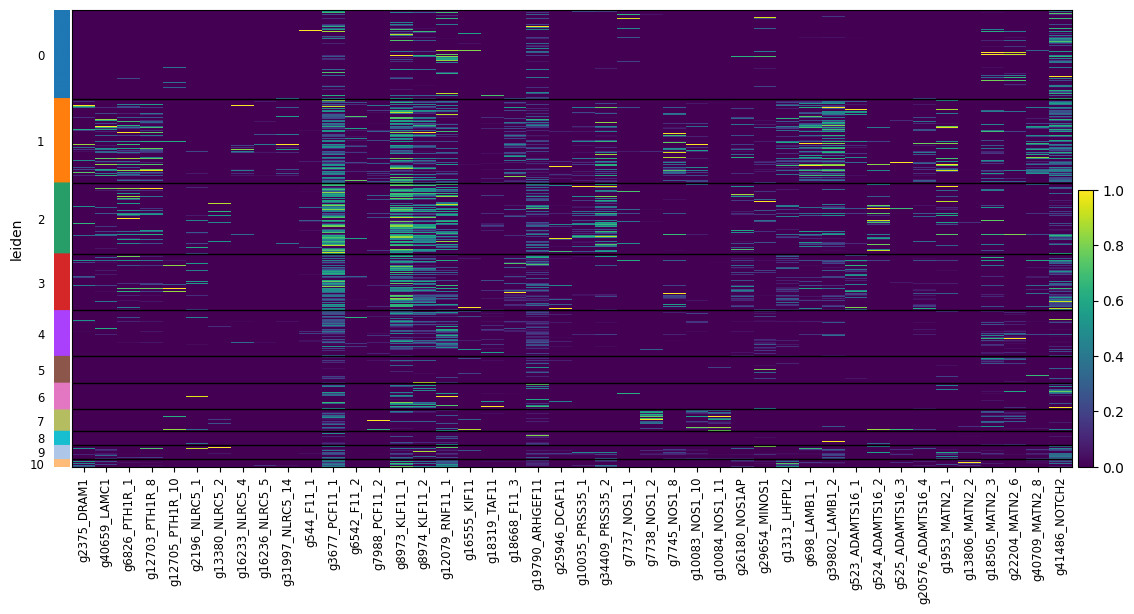

In [ ]:
# Define the gene list
gene_list=['TEKT1', 'QRICH2', 'GAS8', 'CYR61', 'TTC28', 'EFCAB6', 'IMPDH2', 'CCDC39', 'FBXW10', 'STYXL1', 'MNS1', 'L3MBTL3', 'DNALI1', 'RIBC2', 'IP6K1', 'DNAH7', 'RSPH3', 'DNAH1', 'CTNNB1', 'CDH4', 'KIF24', 'UBE2U', 'FRAS1', 'XRRA1', 'WDR16', 'DNAH5', 'EFHC2', 'CCDC37', 'TTC25', 'VASH1', 'DNAAF1', 'RSPH9', 'WDR65', 'ARMC6', 'CCDC63', 'NOX4', 'SPAG8', 'CAP1', 'STK33', 'PKD1', 'DNAH9', 'SPATA18', 'DNAH14', 'ARMC3', 'MDM1', 'DNAH6', 'TANC2', 'NME7', 'DNAI1', 'CCDC40', 'TPPP2', 'SYNE1', 'ARMC4', 'TMEM67', 'KIF12', 'DNAH3', 'DNAH10', 'YAP1', 'DYNC2H1']

# Define a function to find genes in the dataset
def find_genes(*genes, mode='exact'):
    matched_genes = []
    
    # If the user passed a list of genes instead of individual genes
    if type(genes[0]) is not str:
        genes = genes[0]
        
    if mode == 'endswith':
        for g in genes:
            matched_genes.extend([i for i in adata.var_names if i.endswith(g)])
    elif mode == 'exact':
        for g in genes:
            matched_genes.extend([i for i in adata.var_names if i == g])
    elif mode == 'contains':
        for g in genes:
            matched_genes.extend([i for i in adata.var_names if g in i])    
    return matched_genes

# Find the genes in the dataset
matched_genes = find_genes(gene_list, mode='contains')

# Plot UMAP for the matched genes
sc.pl.heatmap(adata, var_names=matched_genes, groupby='leiden', standard_scale='var')

# sc.pl.umap(adata, color=matched_genes, cmap='Reds')

## GO analysis

In [48]:
import os
import pandas as pd
import gseapy as gp

# 1) Load markers
df = pd.read_csv('markers_with_avg_expression_fixed_dataset2.csv')

# 2) Prepare output directory
outdir = "enrichment_results"
os.makedirs(outdir, exist_ok=True)

# 3) Enrich clusters
clusters = [str(i) for i in range(11)]
top_n   = 100

for cl in clusters:
    genes = df[cl].dropna().tolist()[:top_n]
    
    enr = gp.enrichr(
        gene_list = genes,
        gene_sets = ['GO_Biological_Process_2021', 'KEGG_2021_Human'],  # adjust names if needed
        organism  = 'Human',       # or 'Mouse'
        outdir     = os.path.join(outdir, f"cluster_{cl}"),
        cutoff     = 0.05,
        no_plot    = True
    )
    
    # Save results
    res = enr.results
    res.to_csv(
        os.path.join(outdir, f"cluster_{cl}", f"cluster_{cl}_enrichr_results.csv"),
        index=False
    )
    print(f"Cluster {cl}: {len(res)} terms → enrichment_results/cluster_{cl}/")


Cluster 0: 877 terms → enrichment_results/cluster_0/
Cluster 1: 878 terms → enrichment_results/cluster_1/
Cluster 2: 833 terms → enrichment_results/cluster_2/
Cluster 3: 834 terms → enrichment_results/cluster_3/
Cluster 4: 923 terms → enrichment_results/cluster_4/
Cluster 5: 804 terms → enrichment_results/cluster_5/
Cluster 6: 1141 terms → enrichment_results/cluster_6/
Cluster 7: 933 terms → enrichment_results/cluster_7/
Cluster 8: 828 terms → enrichment_results/cluster_8/
Cluster 9: 639 terms → enrichment_results/cluster_9/
Cluster 10: 740 terms → enrichment_results/cluster_10/


In [20]:
!pip install scgena

ERROR: Could not find a version that satisfies the requirement scgena (from versions: none)

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
ERROR: No matching distribution found for scgena


Pre-processing...
	Detecting genes and samples with too many missing values...


	Done pre-processing..



TypeError: WGCNA.pickSoftThreshold() got an unexpected keyword argument 'powers'

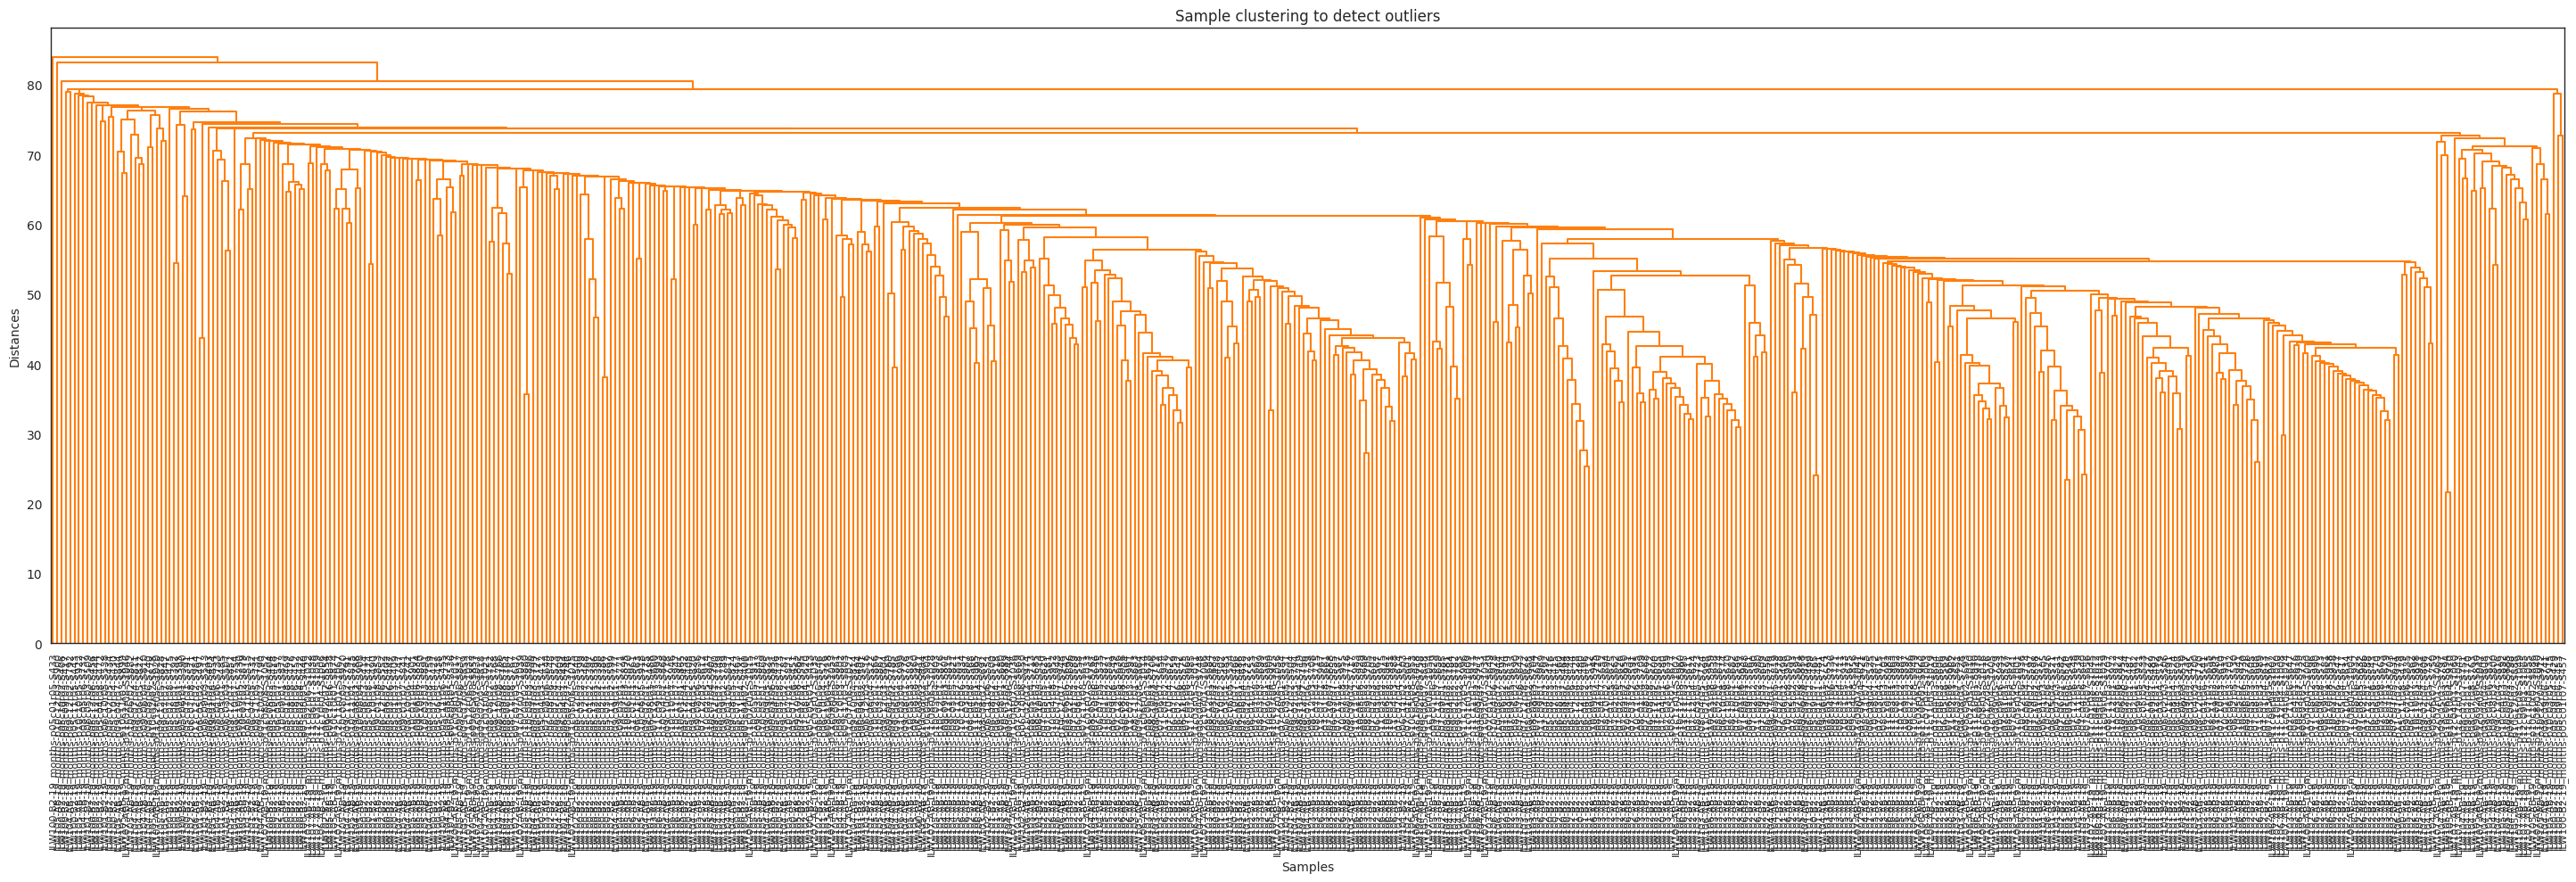

In [24]:
import pandas as pd
import scanpy as sc
from PyWGCNA.wgcna import WGCNA

# 1) Build your expression matrix (cells × genes)
expr_df = pd.DataFrame(
    adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X,
    index=adata.obs_names,
    columns=adata.var_names
)

# OPTIONAL: you can manually filter low‐expressed genes here:
# expr_df = expr_df.loc[:, expr_df.mean(axis=0) > 1.0]

# 2) Initialize WGCNA
wg = WGCNA(
    name="scRNAseq_WGCNA",
    species="Human",        # or "Mouse"
    level="gene",
    geneExp=expr_df,        # genes in columns, cells in rows
    outputPath="wgcna_out", # where outputs go
    save=False              # set True to auto-save plots
)

# 3) (Re-)run its default preprocessing step
wg.preprocess()  # no arguments now

# 4) Choose soft‐thresholding power to approximate scale-free topology
wg.pickSoftThreshold(
    powers=list(range(1, 11)),
    RsquaredCut=0.90
)

# 5) Run the full pipeline: adjacency → TOM → module detection → merge
wg.runWGCNA()

# 6) Extract modules and eigengenes
modules    = wg.dynamicMods          # pandas Series: gene → module label
eigengenes = wg.moduleEigengenes()   # DataFrame: cells × module eigengene (ME_*)
    
# 7) Add eigengenes back to your AnnData
for m in eigengenes.columns:
    adata.obs[f"ME_{m}"] = eigengenes[m].values

# 8) Visualize top 3 modules on your UMAP
top3 = modules.value_counts().nlargest(3).index.tolist()
sc.pl.umap(
    adata,
    color=[f"ME_{m}" for m in top3],
    cmap="viridis",
    size=40,
    wspace=0.4
)


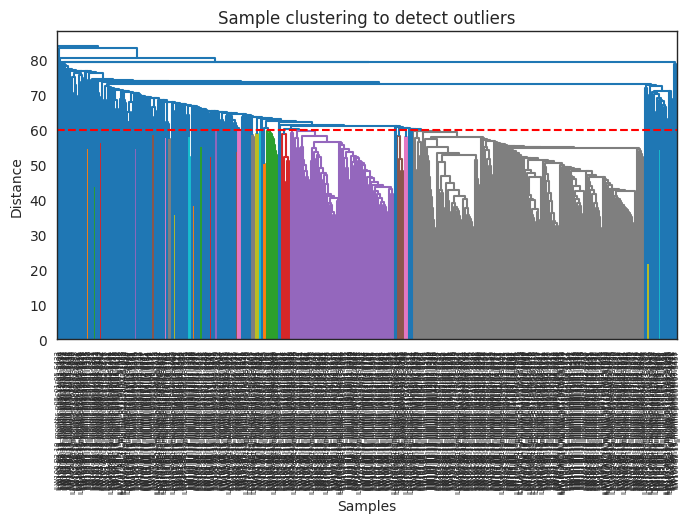

Dropped 580 outlier samples; 1 remain.


In [31]:
import pandas as pd
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

# --- 1) Build or load your cells×genes DataFrame ---
# If you already have expr_df from before, skip this; otherwise:
expr_df = pd.DataFrame(
    adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X,
    index=adata.obs_names,
    columns=adata.var_names
)

# --- 2) Compute pairwise distances between samples (cells) ---
#    Here we use Euclidean, but you can swap in correlation, etc.
dists = pdist(expr_df, metric='euclidean')

# --- 3) Run hierarchical clustering to get the linkage matrix Z ---
Z = linkage(dists, method='average')

# (Optional) Plot to confirm your cutoff visually
plt.figure(figsize=(8,4))
dendrogram(Z, labels=expr_df.index, color_threshold=60)
plt.axhline(60, color='red', linestyle='--')
plt.title("Sample clustering to detect outliers")
plt.ylabel("Distance")
plt.xlabel("Samples")
plt.show()

# --- 4) Cut the tree at your chosen height to define “kept” samples ---
cutoff = 80
cluster_ids = fcluster(Z, t=cutoff, criterion='distance')
# cluster_ids is an integer array; samples assigned to cluster “1” are all those
# merging below the cutoff.
keep_mask = (cluster_ids == 2)

# --- 5) Subset your AnnData to keep only the “good” samples ---
good_samples = expr_df.index[keep_mask]
adata_filtered = adata[good_samples].copy()

print(f"Dropped {len(expr_df) - keep_mask.sum()} outlier samples; {keep_mask.sum()} remain.")


# Pearson‐correlation matrix

In [80]:
df2 = pd.read_csv('/home/pissmaster/Desktop/dataset1/markers_with_avg_expression_fixed_dataset1.csv')
df1 = pd.read_csv('markers_with_avg_expression_fixed_dataset2.csv')

In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict

# =====================================
# Load your two datasets
# =====================================
# df1 = pd.read_csv('markers_with_avg_expression_fixed_dataset1.csv')
# df2 = pd.read_csv('markers_with_avg_expression_fixed_dataset2.csv')

# =====================================
# Identify cluster columns and it's average columns
# =====================================
clusters1 = [c for c in df1.columns if not c.endswith('_avg') and not c.startswith('Unnamed')] 
clusters2 = [c for c in df2.columns if not c.endswith('_avg') and not c.startswith('Unnamed')]

# =====================================
# Helper Functions
# =====================================
def clean_series(series: pd.Series) -> pd.Series:
    """Remove NaNs, strip whitespace, uppercase, and drop empty entries."""
    return (
        series.dropna()
              .astype(str)
              .str.strip()
              .str.upper()
              .loc[lambda x: (x != '') & (x != 'NAN')]
    )

def build_marker_sets_and_avgs(df, clusters):
    """
    Build marker sets and average dictionaries, handling duplicate gene names.
    Returns:
      - marker_sets: {cluster: set(genes)}
      - avg_dicts: {cluster: {gene: avg_expression}}
    """
    # Initialize dictionaries to hold marker sets and average expression values
    marker_sets = {}
    avg_dicts = {}
    for cl in clusters:
        genes = clean_series(df[cl])
        avg_col = f"{cl}_avg" if f"{cl}_avg" in df.columns else f"{cl}.0_avg"
        if avg_col not in df.columns:
            raise ValueError(f"Cannot find avg column for cluster {cl}")
        avg_expr = df[avg_col]

        # collect expression values per gene name
        gene_vals = defaultdict(list)
        for idx, gene in genes.items():
            gene_vals[gene].append(avg_expr.loc[idx])

        # average duplicates
        gene_to_avg = {g: np.mean(vals) for g, vals in gene_vals.items()}

        marker_sets[cl] = set(gene_to_avg.keys())
        avg_dicts[cl] = gene_to_avg
    return marker_sets, avg_dicts

def compute_similarity_matrices_and_genes(clusters1, clusters2,
                                         marker_sets1, marker_sets2,
                                         avg_dict1, avg_dict2,
                                         min_shared=12):
    """
    min_shared: 12 because according to the previous code, this is the minimum number of shared genes to compute Pearson.
    Compute similarity metrics and capture common gene lists for each cluster pair.
    Returns:
      - jaccard: DataFrame
      - pearson: DataFrame
      - shared_counts: DataFrame of counts
      - common_genes: dict[(c1,c2)] = list of shared gene names
    """
    jaccard = pd.DataFrame(index=clusters1, columns=clusters2, dtype=float)
    pearson = pd.DataFrame(index=clusters1, columns=clusters2, dtype=float)
    shared_counts  = pd.DataFrame(index=clusters1, columns=clusters2, dtype=int)
    common_genes = {}

    for c1 in clusters1:
        for c2 in clusters2:
            set1, set2 = marker_sets1[c1], marker_sets2[c2]
            inter = set1 & set2
            union = set1 | set2
            # Fill the DataFrames with the computed values
            shared_counts.loc[c1, c2] = len(inter)
            jaccard.loc[c1, c2] = len(inter) / len(union) if union else np.nan
            common_genes[(c1, c2)] = sorted(inter)
            # Compute Pearson correlation if there are enough shared genes
            if len(inter) >= min_shared:
                v1 = np.array([avg_dict1[c1][g] for g in common_genes[(c1, c2)]])
                v2 = np.array([avg_dict2[c2][g] for g in common_genes[(c1, c2)]])
                pearson.loc[c1, c2] = np.corrcoef(v1, v2)[0, 1] \
                    if np.nanstd(v1) > 0 and np.nanstd(v2) > 0 else np.nan
            else:
                pearson.loc[c1, c2] = np.nan

    return jaccard, pearson, shared_counts, common_genes

def extract_shared_name_matrix(common_genes, clusters1, clusters2):
    """
    Build a DataFrame where each cell contains the list of shared gene names.
    """
    df = pd.DataFrame(index=clusters1, columns=clusters2)
    for (c1, c2), genes in common_genes.items():
        df.loc[c1, c2] = genes
    return df

def counts_from_name_matrix(name_matrix: pd.DataFrame) -> pd.DataFrame:
    """
    Convert a name-matrix (list per cell) into a counts-matrix of list lengths.
    """
    return name_matrix.applymap(lambda x: len(x) if isinstance(x, list) else 0)

def find_best_matches(jaccard: pd.DataFrame,
                      pearson: pd.DataFrame,
                      shared_counts: pd.DataFrame,
                      min_shared=12):
    """
    Identify best matching clusters by Jaccard, Pearson, and shared counts.
    """
    best_jaccard = jaccard.apply(lambda r: r.idxmax() if (r > 0).any() else None, axis=1)
    pearson_masked = pearson.where(shared_counts >= min_shared)
    best_pearson = pearson_masked.apply(lambda r: r.idxmax() if r.notna().any() else None, axis=1)
    best_shared = shared_counts.apply(lambda r: r.idxmax() if (r > 0).any() else None, axis=1)
    return best_jaccard, best_pearson, best_shared

def compute_exclusive_shared(marker_sets1, marker_sets2, clusters1, clusters2):
    """
    For each (c1, c2), return the sorted list of genes that:
      - appear in both marker_sets1[c1] AND marker_sets2[c2]
      - do not appear in ANY other cluster in dataset1 or dataset2
    """
    # pre‐compute unions of all other clusters for speed
    all_other_1 = {
        c1: set().union(*(marker_sets1[c] for c in clusters1 if c != c1))
        for c1 in clusters1
    }
    all_other_2 = {
        c2: set().union(*(marker_sets2[c] for c in clusters2 if c != c2))
        for c2 in clusters2
    }

    exclusive = {}
    for c1 in clusters1:
        for c2 in clusters2:
            inter = marker_sets1[c1] & marker_sets2[c2]
            excl = {g for g in inter if (g not in all_other_1[c1] and g not in all_other_2[c2])}
            exclusive[(c1, c2)] = sorted(excl)
    return exclusive

# =====================================
# Full Execution
# =====================================
marker_sets1, avg_dict1 = build_marker_sets_and_avgs(df1, clusters1)
marker_sets2, avg_dict2 = build_marker_sets_and_avgs(df2, clusters2)

jaccard_df, pearson_df, shared_df, common_genes = \
    compute_similarity_matrices_and_genes(
        clusters1, clusters2,
        marker_sets1, marker_sets2,
        avg_dict1, avg_dict2
    )

# Build name-matrix and count-matrix for shared genes
shared_names_df   = extract_shared_name_matrix(common_genes, clusters1, clusters2)
shared_unique_df  = counts_from_name_matrix(shared_names_df)

# Find best matches by each metric
best_jaccard, best_pearson, best_shared_unique = \
    find_best_matches(jaccard_df, pearson_df, shared_df)

# Compute exclusive shared genes (only in the pair, nowhere else)
exclusive_common     = compute_exclusive_shared(marker_sets1, marker_sets2, clusters1, clusters2)
exclusive_counts_df  = pd.DataFrame(index=clusters1, columns=clusters2, dtype=int)
for (c1, c2), genes in exclusive_common.items():
    exclusive_counts_df.loc[c1, c2] = len(genes)

# Display results
print("Jaccard Matrix:\n", jaccard_df.round(2))
print("\nPearson Matrix:\n", pearson_df.round(2))
print("\nShared Counts Matrix:\n", shared_df)
print("\nUnique Shared Names Count Matrix:\n", shared_unique_df)
print("\nExclusive Shared Counts Matrix (only in that pair):\n", exclusive_counts_df)

print("\nBest by Jaccard:\n", best_jaccard)
print("\nBest by Pearson:\n", best_pearson)
print("\nBest by Shared Names count:\n", best_shared_unique)

# Example: exclusive genes for df1.cluster '0' vs df2.cluster '2'
print("\nExclusive shared genes for 0 ↔ 2 (count={}):".format(
    len(exclusive_common[('0', '2')])))
print(exclusive_common[('0', '2')])


Jaccard Matrix:
        0     1     2     3     4     5     6     7     8     9    10    -1
0   0.00  0.02  0.09  0.02  0.01  0.01  0.02  0.05  0.04  0.01  0.02  0.03
1   0.01  0.01  0.02  0.06  0.01  0.01  0.20  0.02  0.03  0.01  0.05  0.02
2   0.18  0.01  0.02  0.02  0.01  0.01  0.01  0.01  0.01  0.09  0.01  0.02
3   0.01  0.00  0.01  0.02  0.22  0.01  0.03  0.02  0.01  0.01  0.01  0.02
4   0.01  0.18  0.02  0.01  0.01  0.03  0.01  0.05  0.03  0.01  0.01  0.02
5   0.01  0.05  0.03  0.01  0.00  0.02  0.00  0.14  0.03  0.01  0.01  0.02
6   0.01  0.01  0.06  0.01  0.01  0.02  0.01  0.03  0.02  0.01  0.01  0.03
7   0.01  0.02  0.02  0.01  0.00  0.02  0.02  0.05  0.12  0.01  0.02  0.02
8   0.00  0.03  0.02  0.02  0.00  0.18  0.02  0.03  0.02  0.00  0.02  0.02
9   0.02  0.03  0.03  0.03  0.11  0.01  0.04  0.03  0.02  0.02  0.01  0.08
10  0.01  0.01  0.01  0.13  0.01  0.01  0.06  0.02  0.02  0.02  0.02  0.04

Pearson Matrix:
        0     1     2     3     4     5     6     7     8     9   

high count but weak pattern

# List of the genes that are in dataset1 and not dataset2

In [6]:
dfu2= pd.read_csv('/media/pissmaster/atefe/uni/M/botryllus/dataset2/unique_genes_file_2.csv')
dfu1= pd.read_csv('/media/pissmaster/atefe/uni/M/botryllus/dataset1/unique_genes_file_1.csv')




In [8]:
# Convert gene names in both dataframes to lowercase for case-insensitive comparison
dfu1_genes_lower = dfu1['Unique Genes in File 1'].str.lower()
dfu2_genes_lower = dfu2['Unique Genes in File 2'].str.lower()

# Find genes that are in dfu1 but not in dfu2
unique_genes_in_dfu1 = dfu1_genes_lower[~dfu1_genes_lower.isin(dfu2_genes_lower)]

# Convert the result back to a DataFrame
unique_genes_in_dfu1_df = pd.DataFrame(unique_genes_in_dfu1, columns=['Unique Genes in File 1'])

# Display the result
print(unique_genes_in_dfu1_df)

# Save the result to a CSV file if needed
unique_genes_in_dfu1_df.to_csv('unique_genes_in_dfu1.csv', index=False)

     Unique Genes in File 1
0                  serpinb9
1                      stom
2                      pdcl
3                 167534260
4                 kiaa0895l
...                     ...
3630              196000721
3631                slc38a6
3632              270017042
3633                  psip1
3634                    opt

[3635 rows x 1 columns]


# Psuedotime

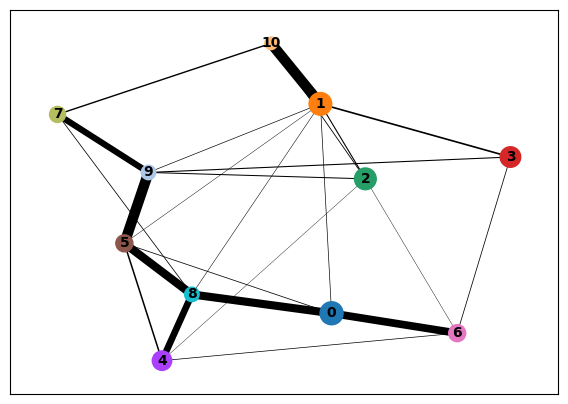

In [38]:
# Step 4: Compute a pseudotime tree using PAGA
sc.tl.paga(adata, groups='leiden')
sc.pl.paga(adata, threshold=0.03, show=True)


In [99]:
# Step 5: Embed the PAGA tree on UMAP and choose a root cell group
adata.uns['iroot'] = adata.obs['leiden'].cat.categories.tolist().index('6')  # Pick the cluster you believe is the starting point (e.g., stem cells)
sc.tl.dpt(adata)

Let’s look at the hubs:
Cluster 0: High connections

Cluster 6: Good connectivity + strong functional score for neural stem cells ✅

Cluster 1: Highly connected — but shows mixed cell type identities (might be mid-state)

Cluster 10: Edge of the graph, probably a terminal state ❌

➤ Cluster 6 has:
High centrality

Strong functional score (4.60 for stem cells)

Good connectivity in PAGA (to Clusters 0, 4, 8)

✅ That makes Cluster 6 an excellent and biologically logical root.

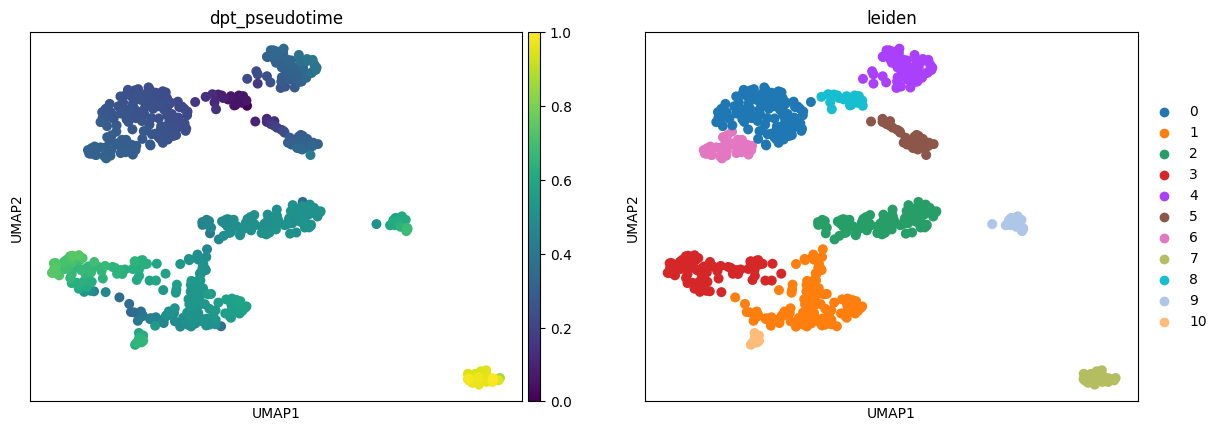

In [100]:
sc.pl.umap(adata, color=['dpt_pseudotime', 'leiden'])
